In [10]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image

In [12]:
model = load_model("/kaggle/input/best-model-512/tensorflow2/default/1/best_model_high_res_512_grayscale.h5")

folder = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
files = os.listdir(folder)
last_conv_layer = "last_conv_layer"

def get_arr_img(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (512, 512))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1) 
    img = np.expand_dims(img, axis=0)
    return img

<strong><center><h1>XAI METHODS</h1></center></strong>

In [22]:

# Saliency map function
def saliency_map(model, img_array, class_index=None):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.Variable(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)  
        if class_index is None:
            class_index = np.argmax(predictions.numpy())  
        
        class_output = predictions[0, class_index]  
    grads = tape.gradient(class_output, img_array)
    saliency = np.abs(grads.numpy()[0])
    return saliency

#_____________________________________________________________________________
# Gradient Input function
def gradient_input(model, img_array, class_index=None):
    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    img_array = tf.Variable(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(img_array)
        predictions = model(img_array)
        if class_index is None:
            class_index = np.argmax(predictions.numpy())
        
        class_output = predictions[0, class_index]

    grads = tape.gradient(class_output, img_array)
    saliency = np.abs(grads.numpy()[0])  
    return saliency
#_____________________________________________________________________________
# SmoothGrad function
def smoothgrad(model, img_array, class_index=None, noise_level=0.1, num_samples=50):
    img_shape = img_array.shape
    smooth_saliency = np.zeros_like(img_array)

    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level, img_shape)
        noisy_img = img_array + noise
        noisy_img = tf.convert_to_tensor(noisy_img, dtype=tf.float32)
        noisy_img = tf.Variable(noisy_img) 
        
        with tf.GradientTape() as tape:
            tape.watch(noisy_img)
            predictions = model(noisy_img)
            if class_index is None:
                class_index = np.argmax(predictions.numpy())
            class_output = predictions[0, class_index]

        grads = tape.gradient(class_output, noisy_img)
        saliency = np.abs(grads.numpy()[0]) 
        smooth_saliency += saliency 

    return smooth_saliency / num_samples

#_____________________________________________________________________________
# Integrated Gradients function
def integrated_gradients(model, img_array, class_index=None, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(img_array)  

    img_array = tf.convert_to_tensor(img_array, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)

    interpolated_images = [
        baseline + (float(i) / steps) * (img_array - baseline) for i in range(steps + 1)
    ]
    
    interpolated_images = tf.reshape(interpolated_images, [(steps + 1) * img_array.shape[0], *img_array.shape[1:]])

    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        predictions = model(interpolated_images)
        if class_index is None:
            class_index = np.argmax(predictions.numpy()[0])  
        class_output = predictions[:, class_index]  
        
    grads = tape.gradient(class_output, interpolated_images) 
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()  
    integrated_grads = (img_array.numpy() - baseline.numpy()) * avg_grads 

    return np.abs(integrated_grads[0])

#_____________________________________________________________________________
# Occlusion Sensitivity function
def occlusion_sensitivity(model, img_array, class_index=None, patch_size=20, stride=10):
    img_shape = img_array.shape[1:3]  
    saliency_map = np.zeros(img_shape) 
    num_patches = np.zeros(img_shape)  

    if class_index is None:
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions[0])  
    for y in range(0, img_shape[0], stride):
        for x in range(0, img_shape[1], stride):
            occluded_img = img_array.copy()
            occluded_img[:, y:y+patch_size, x:x+patch_size, :] = 0 
            pred = model.predict(occluded_img, verbose=0)[0, class_index]
            saliency_map[y:y+patch_size, x:x+patch_size] += pred
            num_patches[y:y+patch_size, x:x+patch_size] += 1
    saliency_map /= np.maximum(num_patches, 1)
    return saliency_map

#_____________________________________________________________________________

# Grad-CAM function
def grad_cam(model, img_array, last_conv_layer_name="last_conv_layer", pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = tf.image.resize(
        heatmap[..., tf.newaxis],  
        (512, 512),
        method=tf.image.ResizeMethod.BILINEAR  
    )
    return heatmap.numpy()

#_____________________________________________________________________________

def gradcam_plus_plus(model, img_array, class_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img_array)
                if class_index is None:
                    class_index = np.argmax(predictions[0])
                output = predictions[:, class_index]

            grads = tape3.gradient(output, conv_outputs)
        first_derivative = tape2.gradient(output, conv_outputs)
    second_derivative = tape1.gradient(first_derivative, conv_outputs)

    conv_outputs = conv_outputs[0]
    grads = grads[0]
    first_derivative = first_derivative[0]
    second_derivative = second_derivative[0]
    numerator = second_derivative
    denominator = 2 * second_derivative + tf.multiply(first_derivative, first_derivative)
    denominator = tf.where(denominator != 0.0, denominator, tf.ones_like(denominator))  # Avoid /0
    alpha = numerator / denominator

    weights = tf.reduce_sum(tf.nn.relu(alpha * grads), axis=(0, 1))
    cam = np.zeros(conv_outputs.shape[:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * conv_outputs[:, :, i]
    cam = np.maximum(cam, 0)
    cam /= np.max(cam) if np.max(cam) != 0 else 1
    return cam

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


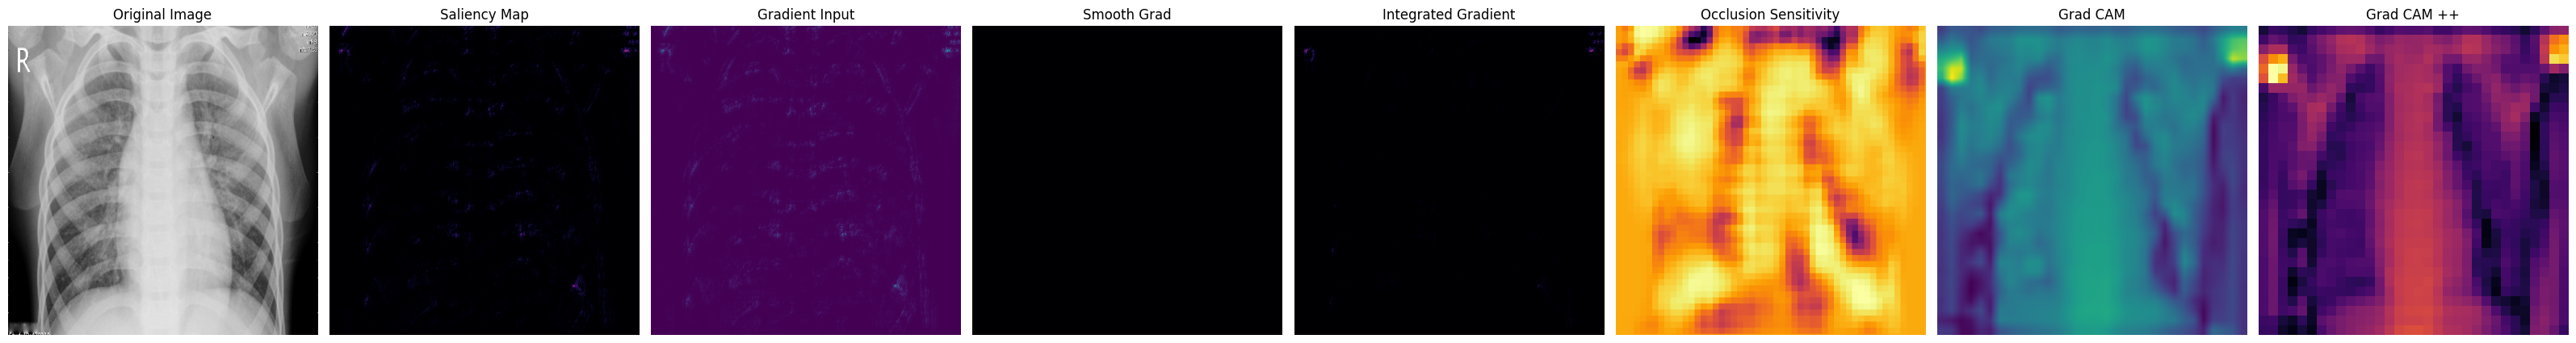

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


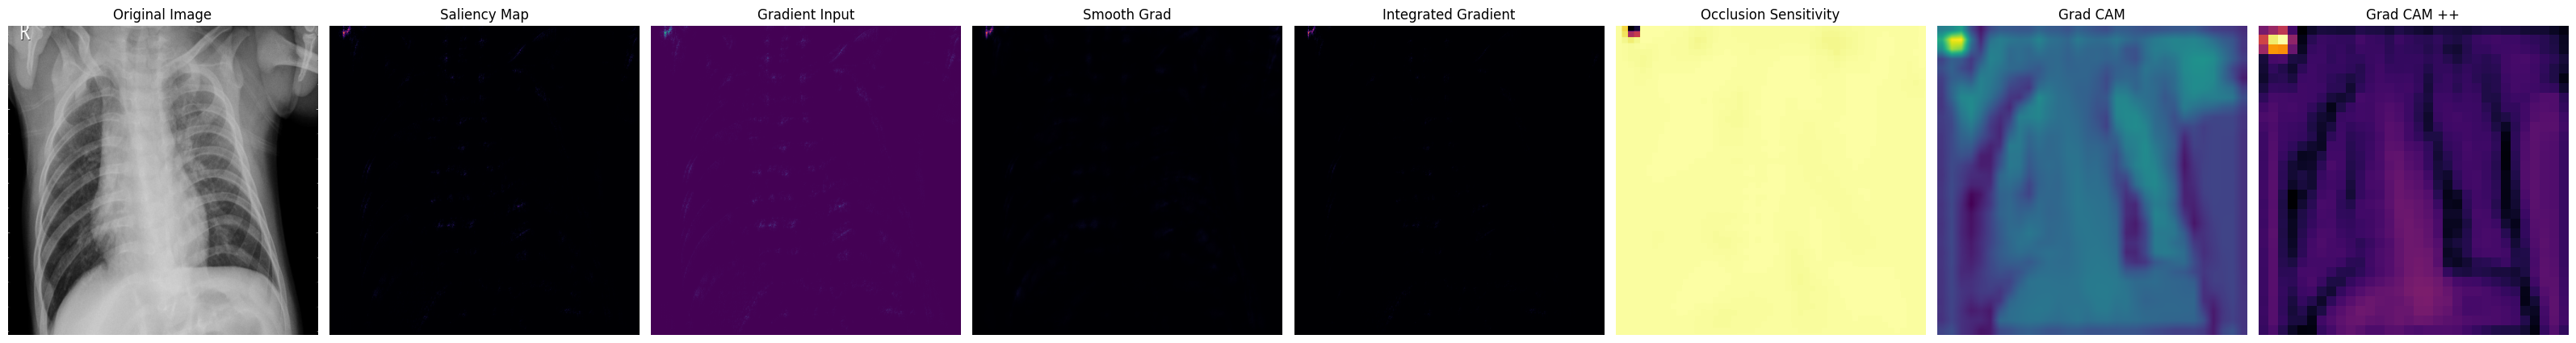

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


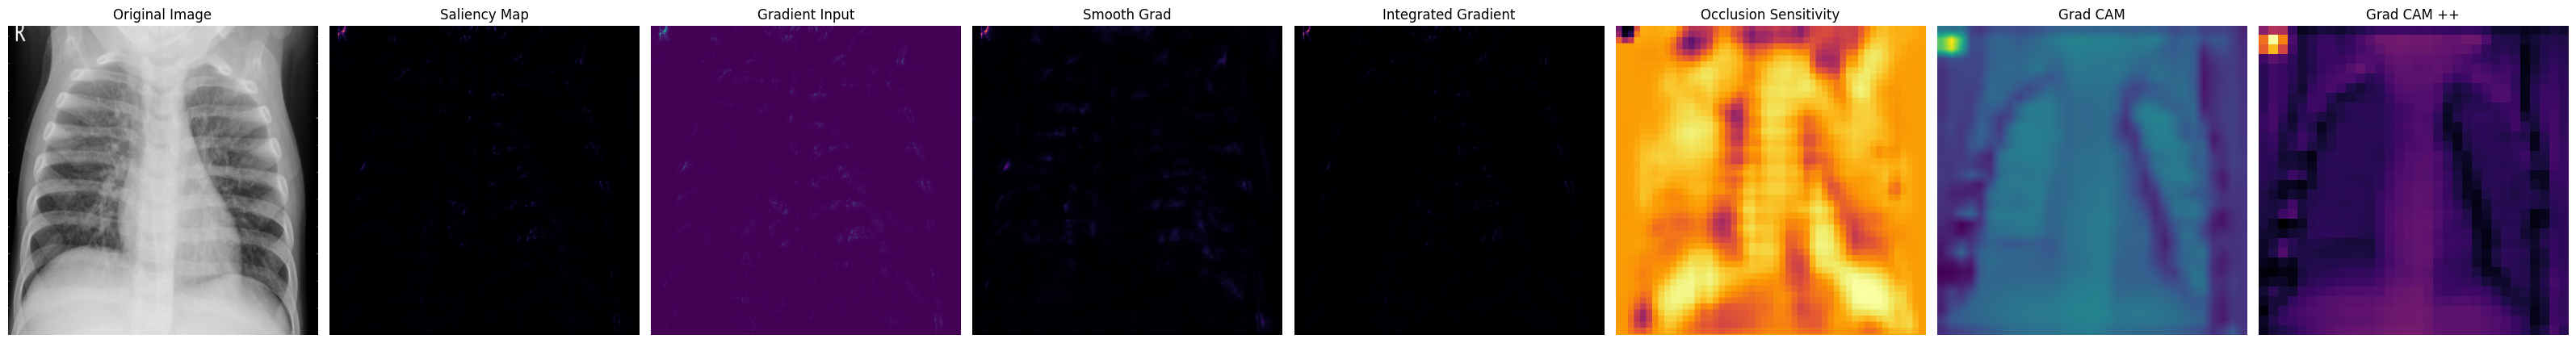

In [28]:
for img in files[:3]:
    
    # Apply Saliency Map
    img_path = os.path.join(folder, img)
    img_array = get_arr_img(img_path)
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    
    saliency = saliency_map(model, img_array, class_index=predicted_class)
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (512, 512))
    
    original_img = original_img.astype("float32") / 255.0
    
    saliency_resized = cv2.resize(saliency, (original_img.shape[1], original_img.shape[0]))
    superimposed_img = original_img + np.expand_dims(saliency_resized, axis=-1)
    
    # Apply Gradient input
    gi = gradient_input(model, img_array, class_index=predicted_class)
    gi_resi = cv2.resize(gi, (original_img.shape[1], original_img.shape[0]))

    # Apply Smooth grad
    smooth_saliency = smoothgrad(model, img_array, class_index=predicted_class, noise_level=0.1, num_samples=50)
    smooth_saliency = np.squeeze(smooth_saliency) 
    smooth_saliency_resized = cv2.resize(smooth_saliency, (original_img.shape[1], original_img.shape[0]))

    #apply Integrated gradient
    integrated_saliency = integrated_gradients(model, img_array, class_index=predicted_class, steps=50)
    integrated_saliency_resized = cv2.resize(np.squeeze(integrated_saliency), 
                                         (original_img.shape[1], original_img.shape[0]))


    # Apply occlusion
    occlusion_saliency = occlusion_sensitivity(model, img_array, class_index=predicted_class, patch_size=20, stride=10)
    occlusion_saliency_resized = cv2.resize(occlusion_saliency, 
                                        (original_img.shape[1], original_img.shape[0]))

    # Apply Grad CAM
    g_heatmap = grad_cam(model, img_array)

    # Apply Grad CAM ++
    cam_pp = gradcam_plus_plus(model, img_array, predicted_class)


    fig, axes = plt.subplots(1, 8, figsize=(32, 10))
    axes[0].imshow(original_img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    axes[1].imshow(saliency_resized, cmap='inferno')
    axes[1].set_title("Saliency Map")
    axes[1].axis('off')
    axes[2].imshow(gi_resi)
    axes[2].set_title("Gradient Input")
    axes[2].axis('off')
    axes[3].imshow(smooth_saliency_resized, cmap='inferno')
    axes[3].set_title("Smooth Grad")
    axes[3].axis('off')
    axes[4].imshow(integrated_saliency_resized, cmap='inferno')
    axes[4].set_title("Integrated Gradient")
    axes[4].axis('off')
    axes[5].imshow(occlusion_saliency_resized)
    axes[5].set_title("Occlusion Sensitivity")
    axes[5].axis('off')
    axes[6].imshow(g_heatmap)
    axes[6].set_title("Grad CAM")
    axes[6].axis('off')
    axes[7].imshow(cam_pp, cmap='inferno')
    axes[7].set_title("Grad CAM ++")
    axes[7].axis('off')
    
    plt.tight_layout()
    plt.show()